<div style="background-image: url('https://images.unsplash.com/photo-1518021964703-4b2030f03085?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60'); background-size: 40%; background-repeat: no-repeat; background-position: right;">

# Shifted Schwefel’s Problem 2.21

$F_2(x) = max_i{\{|z_i|,1 \leq i \leq D}\} + f_{bias_2}$, $ z = x - o $, $x = [x_1,x_2,...,x_D]$

D: dimensions. $o = [o_1, o_2, ..., o_D]$ : the shifted global optimum.

### Properties:
- Unimodal
- Shifted
- Non-separable
- Scalable
- Dimension D as 100, 500 and 1000
- $x∈[−100,100]^D$ , Global optimum: x* = o , $F_2(x^*) = f_{bias_2} = - 450$
    
</div>

In [1]:
import sys
sys.path.append('../') # just to allow using python files at another directory

import numpy as np
from shifted_go import * # shifted global optimum of the functions
from algorithms import * # optimization algorithms customized
from utils import * # functions used to summarise the results

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pygmo as pg # package with the optimization algorithms
import time
import pandas as pd

## I. Defining the class for the optimization algorithm
<hr>

In [2]:
class shifted_schwefel:
    
    def __init__(self, dim):
        self.dim = dim
        self.name = 'Shifted Schwefel Problem 2.21'

    def fitness(self, x):
        z = np.array(x)
        if z.ndim <= 1:
            if np.isscalar(x) == True:
                z = np.amax(np.abs(z - np.array(schwefel[0])))
            else:
                z = np.amax(np.abs(z - np.array(schwefel[:len(z)])))
            res =  z + f_bias[1]         
        else:
            z = np.amax(np.abs(z - np.array(schwefel[:z.shape[1]])),axis=1)
            if z.ndim > 1:
                res =  z[0] + f_bias[1]  
            else:
                res =  z + f_bias[1]    
        
        return [res]
    
    def get_bounds(self):
        return ([-100]*self.dim,[100]*self.dim)
    
    def get_nic(self): # number of inequality constraints
        return 0
    
    def get_nec(self): # number of equality constraints
        return 0
    
    def get_name(self): # number of equality constraints
        return self.name + ' - dimension ' + str(self.dim)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

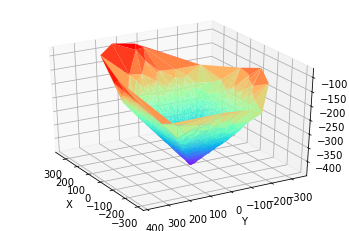

In [3]:
grid = 100*np.random.randn(2000, 2)
function = shifted_schwefel(2)
z = function.fitness(grid)
ax = plt.axes(projection='3d')

ax.plot_trisurf(grid[:,0], grid[:,1], np.array(z).flatten(), cmap='rainbow', linewidth=1)
ax.view_init(30,-210)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# II. Optimizing the function using metaheuristics

<hr>

## II.1 Dimension = 50 

Based on the key point that CMA can improve the performance of non-separable problems and that it is the stateof-the-art in continuous domain evolutionary algorithm we are going to use it on the shifted Schwefel optimization.

### Parameters selection

Once PyGMO provides a version of CMA-ES that optimizes the parameters cc, cs, c1, cmu and sigma and it's results are good when compared to manually selection, we are going to use the default values. We are going to evaluate the number of generations and the population size.

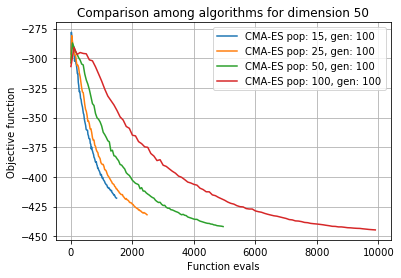

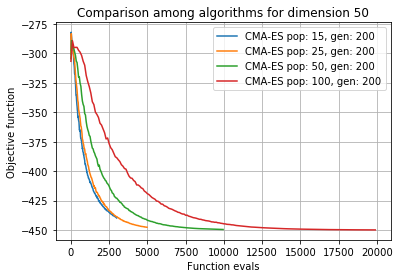

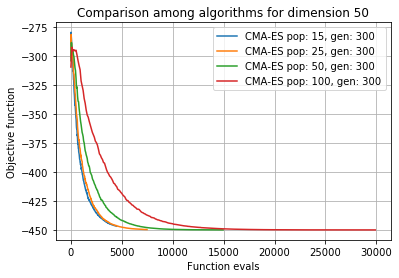

In [4]:
prob = pg.problem(shifted_schwefel(50))
stats = []

populations = [15, 25, 50, 100, 15, 25, 50, 100, 15, 25, 50, 100]
generations = [100, 100, 100, 100, 200, 200, 200, 200, 300, 300, 300, 300]
ctr = ''

fig = plt.figure()
for gen, pop_size in zip(generations, populations): 
    logs = []
    best = []
    evals = []
    start_time = time.time()
    for i in range(25):
        algo = pg.algorithm(pg.cmaes(gen=gen, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=.5, ftol=1e-9, 
            xtol=1e-9, memory=False, force_bounds=True))
        algo.set_verbosity(1) # regulates both screen and log verbosity
        pop = pg.population(prob, pop_size)
        sol = algo.evolve(pop)
        logs.append(algo.extract(pg.cmaes).get_log())
        best.append(sol.champion_f)
        evals.append(sol.problem.get_fevals())
    
    end_time = time.time()
    logs = np.array(logs)
    stats.append(['population: '+ str(pop_size) + ', generations: '+str(gen), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])
    avg_log = np.average(logs,0)
    plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name().split(':')[0] + ' pop: '+ str(pop_size) + ', gen: '+str(gen))
    if ctr == '':
        ctr = gen
    elif pop_size ==100:
        ctr = gen
        plt.title('Comparison among algorithms for dimension ' + str(prob.get_nx()))
        plt.xlabel('Function evals')
        plt.ylabel('Objective function')
        plt.legend() 
        plt.grid() 
        plt.show()

In [5]:
df_stats = pd.DataFrame(stats, columns=['parameters', 'avg computational time (sec)', 'avg function evals' , 
                                        'max', 'min', 'avg', 'median'])
df_stats

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"population: 15, generations: 100",0.110032,1515.0,-406.592538,-429.262952,-420.084660,-420.509827
1,"population: 25, generations: 100",0.173368,2525.0,-427.311280,-438.357687,-433.048031,-432.816175
2,"population: 50, generations: 100",0.290035,5050.0,-440.225151,-444.614436,-442.651957,-442.887728
3,"population: 100, generations: 100",0.536869,10100.0,-442.688951,-446.540918,-445.097446,-445.282375
4,"population: 15, generations: 200",0.213538,3015.0,-429.014901,-444.709015,-440.140793,-440.822160
5,"population: 25, generations: 200",0.301848,5025.0,-446.756710,-448.836248,-447.774610,-447.640222
6,"population: 50, generations: 200",0.541143,10050.0,-449.152746,-449.706560,-449.538781,-449.579499
7,"population: 100, generations: 200",1.022540,20100.0,-449.782257,-449.925642,-449.864276,-449.872653
8,"population: 15, generations: 300",0.328768,4515.0,-444.268222,-448.488441,-446.927802,-446.896827
9,"population: 25, generations: 300",0.467384,7525.0,-449.395316,-449.808670,-449.685102,-449.706394


As we can observe the algorithm converges fast to a point near the optimal solution, but from this point on the convergence to the optimal is really slow. We can see that once we increase the number of generations higher number of individuals do not bring any exceptional improvement to the fitness of the function.

#### a) Fast and Good Accuracy

Below we present the best solution found in a range of 25 runs of the algorithm from a population of 50 individuals with 200 generations, where the number of evaluations considers the total throughout all runs.

Number of function evaluations:  187500.0
Final solution vector:  [-27.09951093  -4.73234336 -56.62793665 -95.14621284  -4.40881591
 -50.46378747  -2.61114463 -84.7952731  -74.63428231 -60.30481288
 -61.15958822 -53.91988664  -4.56210093 -28.68921201 -87.37349573
 -56.43253955 -50.86812916 -42.93999869 -78.49363518 -76.6425935
 -47.87368667 -78.99826296 -65.37487447 -55.25892438  -6.82590768
 -31.3714896  -22.02204014 -72.0420897  -55.58643898 -47.01020425
 -74.99378875 -71.97155862 -50.52615984 -63.18362941 -96.76431189
 -81.61206352 -96.41794526 -53.27880738 -60.0329073  -63.13568371
  -5.80386478 -72.19795459 -21.97438083 -48.58626223  -2.24751477
 -82.00383924 -13.81284972 -68.15356849 -37.02360463 -83.51877818]
Fitness:  [-449.78838791]
Wall time: 13.3 s


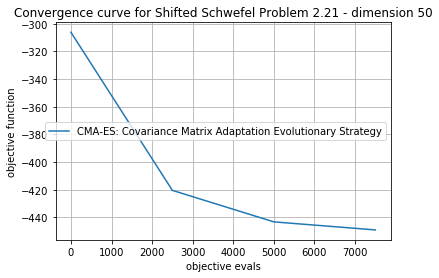

In [6]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = cmaes(shifted_schwefel(50), gen=200, cc=- 1, cs=- 1, c1=- 1, cmu=- 1, sigma0=-1, ftol=1e-09, 
            xtol=1e-09, memory=False, force_bounds=True, pop_size = 50)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

#### b) Accuraccy

If we decide to privilege accuracy it's necessary to increase substantially the number of generations, and we can even reduce the number of individuals.

Number of function evaluations:  718750.0
Final solution vector:  [-26.88789884  -4.90903041 -56.82602541 -95.0436696   -4.33977568
 -50.29706886  -2.75289886 -84.85615341 -74.5337273  -60.38027439
 -61.20629046 -53.79117548  -4.57308692 -28.68521742 -87.25376791
 -56.48486646 -50.78741553 -42.89537331 -78.49578056 -76.62817567
 -47.80620519 -78.91999864 -65.53260072 -55.28958734  -6.8978558
 -31.46403573 -22.1279746  -71.8624828  -55.59740568 -47.01394993
 -75.02727078 -72.12981268 -50.36871813 -62.99448664 -96.77179229
 -81.60507137 -96.62765606 -53.3360997  -60.05551455 -63.20197214
  -5.80914325 -72.12204782 -21.86907842 -48.63138485  -2.33450367
 -82.18599215 -13.86416463 -68.07465509 -37.04968424 -83.46476402]
Fitness:  [-450.]
Wall time: 45.6 s


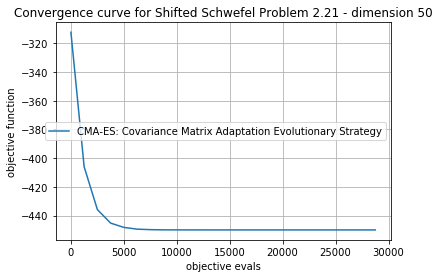

In [7]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = cmaes(shifted_schwefel(50), gen=1200, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=-1, ftol=1e-09, 
            xtol=1e-09, memory=False, force_bounds=True, pop_size = 25)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

<hr>

## II.2 Dimension = 500

Schwefel’s problem 2.21 is unimodal so we are going to use simulated annealing to build a trajectory towards the global optimum.

### Parameters selection

Given the characteristics Schwefel function we don't need to start with a high temperature to reduce the probability of getting stuck at a local minima. Since it's a trajectory algorithm, there is no influence at all the increase of the population size. 

The final temperature will be set to a small number in such a way that we reduce the probability to accept solutions that do not improve the fitness. The parameters that define the number of temperature and range adjustments, as well the number of mutations that are used to compute the acceptance rate are going to be defined empirically.

In [8]:
udas = [pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=10, n_range_adj=5, bin_size=5, start_range=1), 
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=15, n_range_adj=10, bin_size=10, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=25, n_range_adj=10, bin_size=10, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=25, n_range_adj=15, bin_size=15, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=25, n_range_adj=20, bin_size=10, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=25, n_range_adj=25, bin_size=15, start_range=1)]

df = statistics(shifted_schwefel(500), udas, epochs = 1)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 10, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 2191330987, Verbosity: 1]",0.221879,125001,-366.865894,-366.865894,-366.865894,-366.865894
1,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 15, Number of range adjustments: 10, Bin size: 10, Starting range: 1, Seed: 3717467184, Verbosity: 1]",1.341354,750001,-431.515569,-431.515569,-431.515569,-431.515569
2,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 25, Number of range adjustments: 10, Bin size: 10, Starting range: 1, Seed: 3543674253, Verbosity: 1]",2.195044,1250001,-442.617380,-442.617380,-442.617380,-442.617380
3,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 25, Number of range adjustments: 15, Bin size: 15, Starting range: 1, Seed: 1005974090, Verbosity: 1]",4.893191,2812501,-449.763222,-449.763222,-449.763222,-449.763222
4,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 25, Number of range adjustments: 20, Bin size: 10, Starting range: 1, Seed: 2562825960, Verbosity: 1]",4.367445,2500001,-449.500891,-449.500891,-449.500891,-449.500891
5,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 25, Number of range adjustments: 25, Bin size: 15, Starting range: 1, Seed: 1023694571, Verbosity: 1]",8.280133,4687501,-449.995503,-449.995503,-449.995503,-449.995503


After analyzing the statistics of the different parameters we decide for the following configuration:

- Ts = 1
- Tf = 1e-12
- n_T_adj = 25
- n_range_adj = 25
- bin_size = 15
- start_range = 1

Number of function evaluations:  4687500.0
Final solution vector:  [-2.68845225e+01 -4.91342804e+00 -5.68207920e+01 -9.50504050e+01
 -4.34340963e+00 -5.03011817e+01 -2.74833233e+00 -8.48498942e+01
 -7.45306462e+01 -6.03873982e+01 -6.12069067e+01 -5.37884972e+01
 -4.57350532e+00 -2.86913176e+01 -8.72530281e+01 -5.64842964e+01
 -5.07883550e+01 -4.29009375e+01 -7.85020936e+01 -7.66288746e+01
 -4.78111563e+01 -7.89204206e+01 -6.55386922e+01 -5.52910919e+01
 -6.89413177e+00 -3.14570138e+01 -2.21237398e+01 -7.18576720e+01
 -5.55961377e+01 -4.70096414e+01 -7.50256229e+01 -7.21277016e+01
 -5.03628841e+01 -6.29924711e+01 -9.67790321e+01 -8.15997324e+01
 -9.66264055e+01 -5.33388787e+01 -6.00609328e+01 -6.31980776e+01
 -5.80394562e+00 -7.21148260e+01 -2.18680652e+01 -4.86366410e+01
 -2.32946082e+00 -8.21926714e+01 -1.38671040e+01 -6.80761175e+01
 -3.70470446e+01 -8.34642267e+01 -6.15044893e+00 -4.78970931e+01
 -3.97897673e+01 -2.98602158e+01 -2.49042541e+00 -4.84119266e+01
 -4.04594522e+01 -9.529

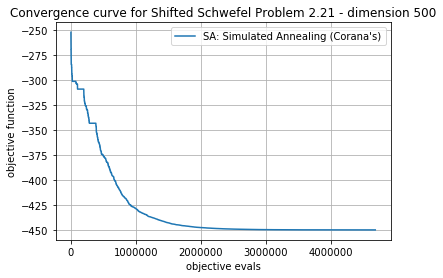

In [9]:
%%time
best = []
fevals = 0
sol = sa(shifted_schwefel(500), Ts=1, Tf=1e-12, n_T_adj=25, n_range_adj=25, bin_size=15, start_range=.5, pop_size=1)

report_convergence(sol)